# Machine Learning Algorithms Comparitive Analysis for estimation of HbA1c levels


### Importing Libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
)
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import unittest

### Importing Dataset


In [2]:
df = pd.read_csv("../../../Dataset/synthetic_diabetes_data_v6.csv")
df.head()

,Patient_ID,Timestamp,Age,Gender,BMI,Blood_Glucose,HbA1c
0,1,2024-01-28 00:00:00,56,Male,22.47,61.09,3.9
1,1,2024-01-28 08:00:00,56,Male,22.47,58.23,3.9
2,1,2024-01-28 16:00:00,56,Male,22.47,95.74,3.9
3,1,2024-01-29 00:00:00,56,Male,22.47,84.66,3.9
4,1,2024-01-29 08:00:00,56,Male,22.47,76.96,3.9


In [3]:
# Checking for null values
df.isna().sum()

Patient_ID       0
Timestamp        0
Age              0
Gender           0
BMI              0
Blood_Glucose    0
HbA1c            0
dtype: int64

In [4]:
# Checking for df types
df.info()

# Coverting columns to lower case
df.columns = map(str.lower, df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient_ID     13230 non-null  int64  
 1   Timestamp      13230 non-null  object 
 2   Age            13230 non-null  int64  
 3   Gender         13230 non-null  object 
 4   BMI            13230 non-null  float64
 5   Blood_Glucose  13230 non-null  float64
 6   HbA1c          13230 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 723.6+ KB


In [5]:
# Describe the data
df.describe().style.format("{:.2f}")

,patient_id,age,bmi,blood_glucose,hba1c
count,13230.00,13230.00,13230.00,13230.00,13230.00
mean,25.00,51.88,29.37,124.15,5.90
std,14.14,18.87,6.40,35.39,0.95
min,1.00,19.00,18.62,50.00,3.80
25%,13.00,38.00,24.33,97.47,5.60
50%,25.00,50.00,29.74,126.21,6.20
75%,37.00,70.00,35.08,149.24,6.60
max,49.00,81.00,39.72,242.17,7.30


### Data Visualization


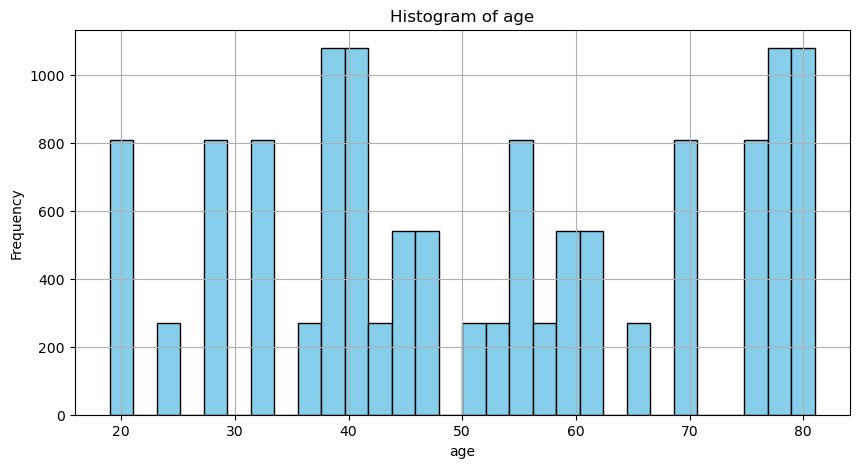

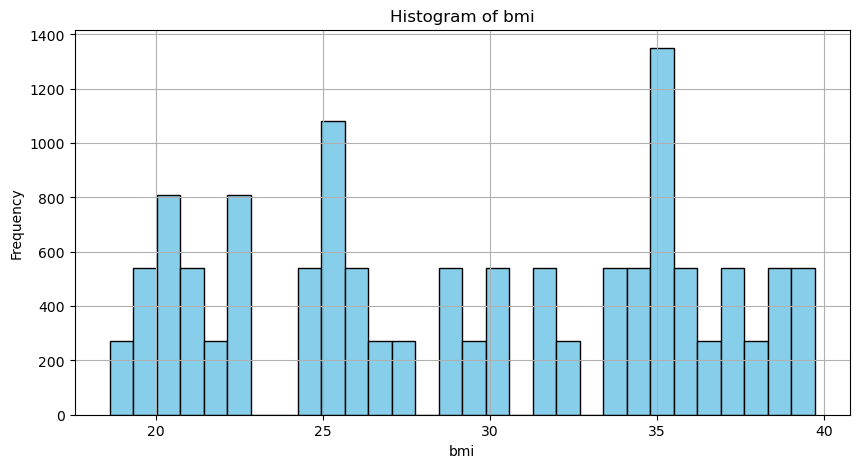

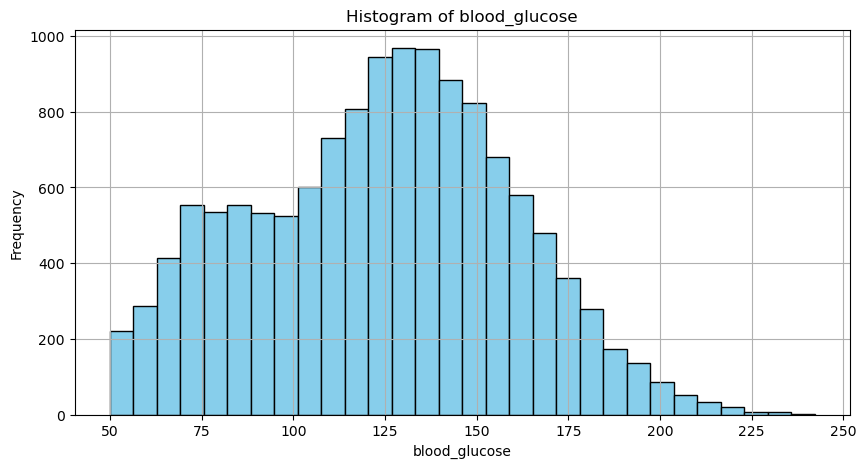

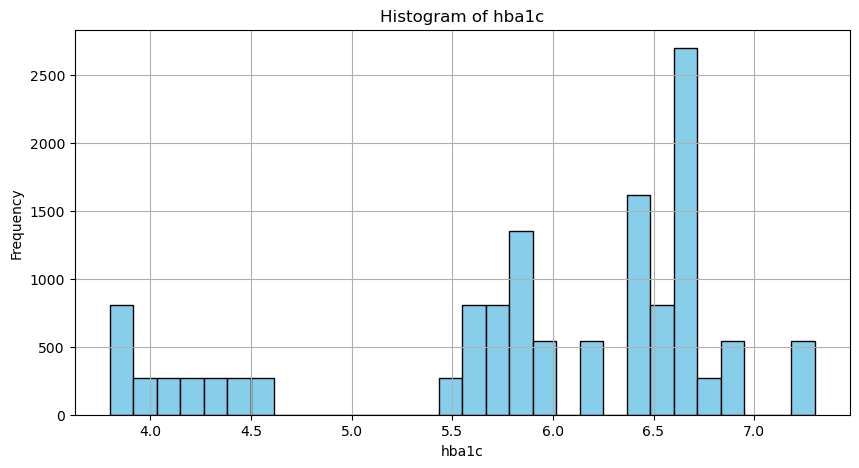

In [6]:
columns = ["age", "bmi", "blood_glucose", "hba1c"]

for col in columns:
    plt.figure(figsize=(10, 5))
    plt.hist(df[col], bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

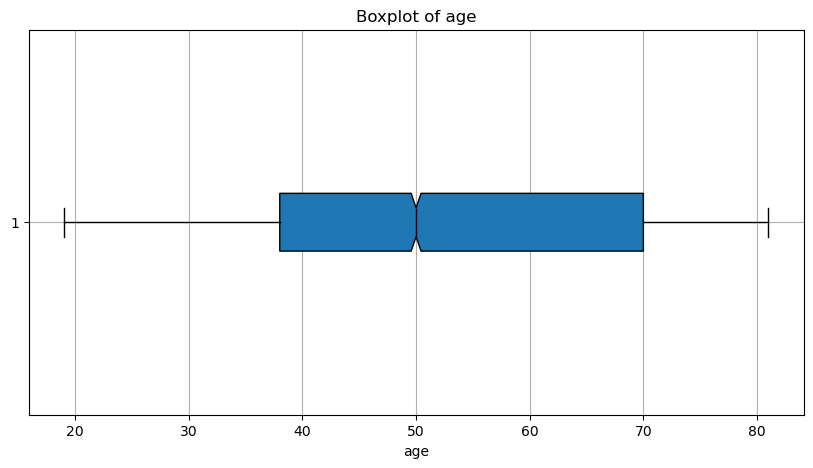

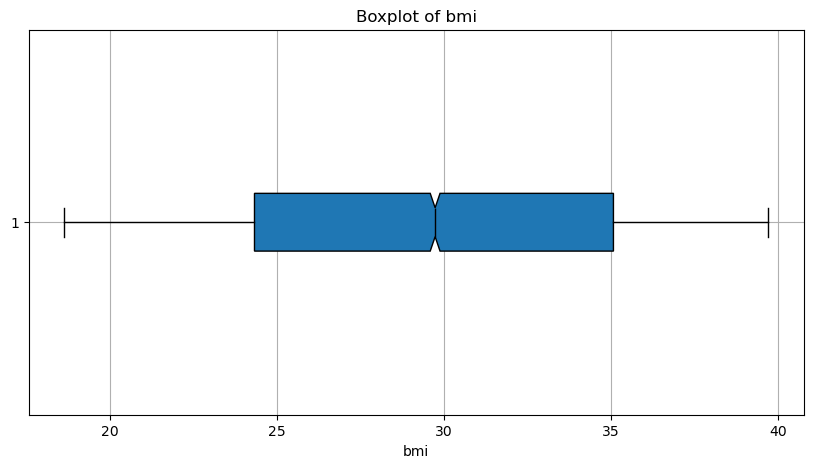

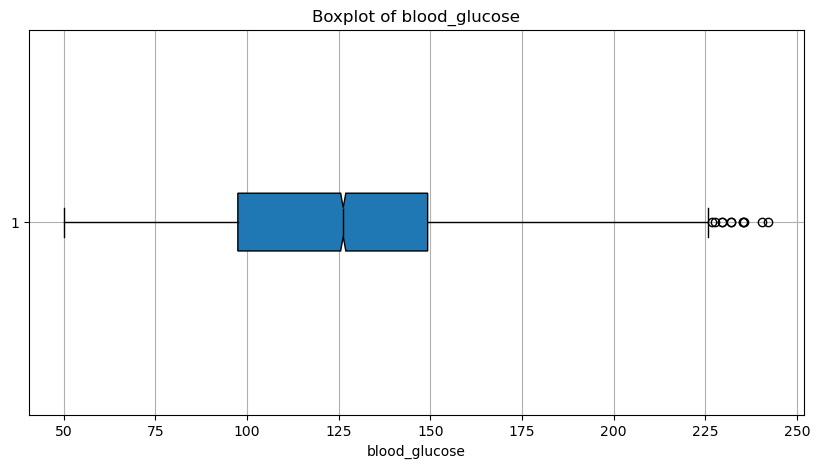

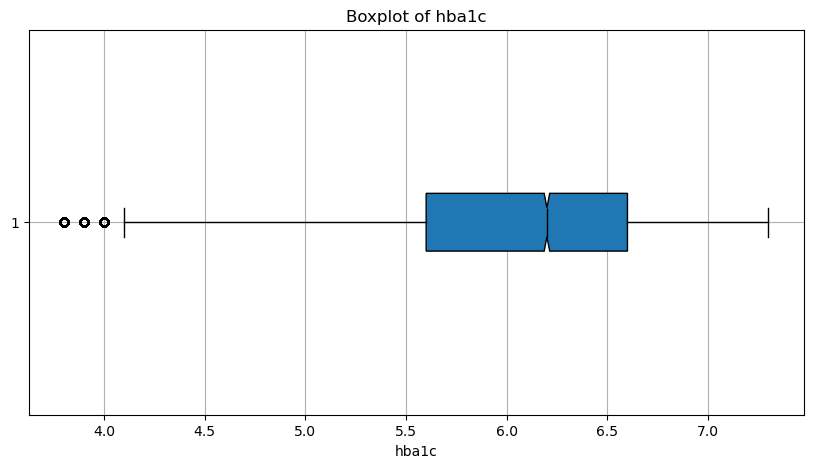

In [7]:
for col in columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(
        df[col],
        vert=False,
        patch_artist=True,
        notch=True,
        medianprops={"color": "black"},
    )
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


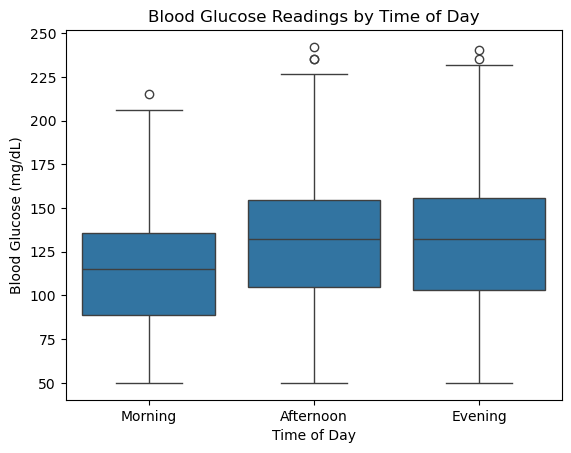

In [8]:
## Daily Variability in Glucose Readings
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["Time_of_Day"] = df["timestamp"].dt.hour
sns.boxplot(x="Time_of_Day", y="blood_glucose", data=df)
plt.title("Blood Glucose Readings by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Blood Glucose (mg/dL)")
plt.xticks(ticks=[0, 1, 2], labels=["Morning", "Afternoon", "Evening"])
plt.show()

In [9]:
# Print a table with the highest counts of HbA1c values
hba1c_counts = df["hba1c"].value_counts()
hba1c_counts.head()

hba1c
6.4    1620
6.6    1620
5.8    1350
6.7    1080
5.6     810
Name: count, dtype: int64

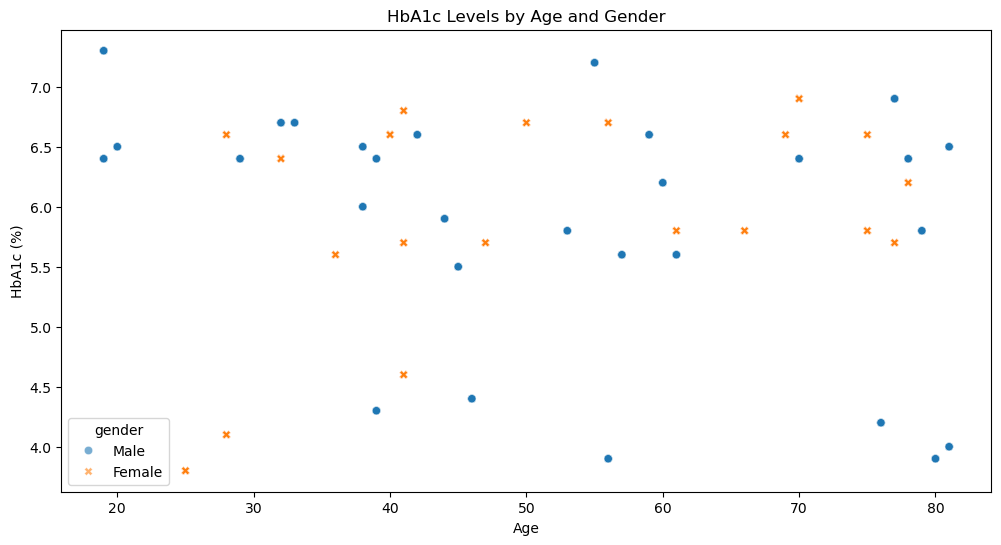

In [10]:
# Explore the relationship between BMI, Age, Gender, and HbA1c levels
plt.figure(figsize=(12, 6))
sns.scatterplot(x="age", y="hba1c", hue="gender", style="gender", data=df, alpha=0.6)
plt.title("HbA1c Levels by Age and Gender")
plt.xlabel("Age")
plt.ylabel("HbA1c (%)")
plt.show()

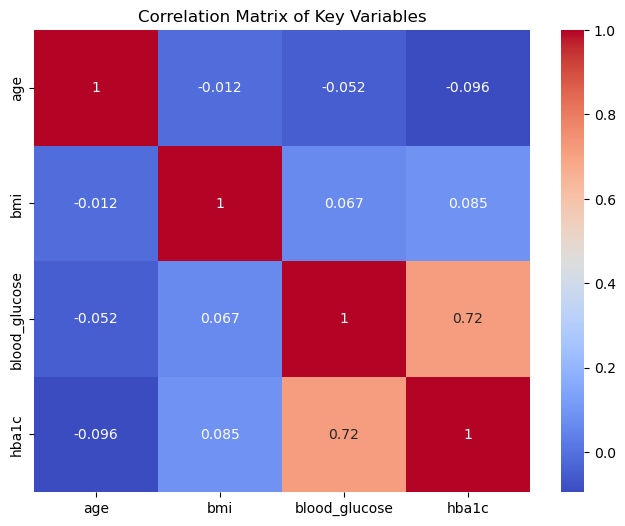

In [11]:
# Correlation matrix to explore potential relationships between variables
corr_matrix = df[["age", "bmi", "blood_glucose", "hba1c"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Key Variables")
plt.show()

### Data Preprocessing


In [12]:
window = 21 // 3  # Calculate rolling windows based on 3 readings per day

data = df
data["timestamp"] = pd.to_datetime(data["timestamp"])
data["date"] = data["timestamp"].dt.date
grouped = data.groupby(["patient_id", "date"])
daily_data = (
    grouped["blood_glucose"].agg(["mean", "median", "std", "max", "min"]).reset_index()
)
daily_data["hba1c"] = grouped["hba1c"].first().values

# Rolling features calculated for each glucose statistic
for feature in ["mean", "median", "std", "max", "min"]:
    daily_data[f"{feature}_rolling_mean"] = daily_data.groupby("patient_id")[
        feature
    ].transform(lambda x: x.rolling(window, min_periods=1).mean())
    daily_data[f"{feature}_rolling_std"] = daily_data.groupby("patient_id")[
        feature
    ].transform(lambda x: x.rolling(window, min_periods=1).std())

# Calculate summary statistics
daily_data["rolling_mean"] = daily_data[
    [f"{feature}_rolling_mean" for feature in ["mean", "median", "std", "max", "min"]]
].mean(axis=1)
daily_data["rolling_median"] = daily_data[
    [f"{feature}_rolling_mean" for feature in ["mean", "median", "std", "max", "min"]]
].median(axis=1)
daily_data["rolling_std"] = daily_data[
    [f"{feature}_rolling_std" for feature in ["mean", "median", "std", "max", "min"]]
].std(axis=1)

preprocessed_data = daily_data.dropna()[
    ["rolling_mean", "rolling_median", "rolling_std", "hba1c"]
]

In [13]:
# Splitting the data into features and target
X = preprocessed_data.drop(columns="hba1c")
y = preprocessed_data["hba1c"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Creating a pipeline for the model
preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), X.columns)])

### Build and Train the Models


In [14]:
# Creating a dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(),
}

# Creating a dictionary of pipelines
pipelines = {
    name: Pipeline([("preprocessor", preprocessor), ("model", model)])
    for name, model in models.items()
}

### Evaluate the Models


In [15]:
# Evaluating the models
results = pd.DataFrame(columns=["Model", "MAE", "MSE", "R2"])
i = 0

for name, pipeline in pipelines.items():
    # Fit the model on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Store the results
    results.loc[i] = [
        name,
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred),
    ]
    i += 1

results

,Model,MAE,MSE,R2
0,Linear Regression,0.209984,0.070197,0.924742
1,Random Forest,0.179082,0.057434,0.938425
2,K-Nearest Neighbors,0.183482,0.058575,0.937201
3,XGBoost,0.183138,0.059656,0.936042


### Hyperparamter Tuning


In [16]:
# Hyperparameter tuning for every model
param_grids = {
    "Linear Regression": {
        "model__fit_intercept": [True, False],
        "model__copy_X": [True, False],
        "model__positive": [True, False],
    },
    "Random Forest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [5, 10, 15],
        "model__min_samples_split": [2, 5, 10],
    },
    "K-Nearest Neighbors": {
        "model__n_neighbors": [3, 5, 11],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"],
    },
    "XGBoost": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [5, 10, 15],
        "model__learning_rate": [0.01, 0.1, 0.3],
    },
}

# Creating a dictionary of GridSearchCV objects
grid_searches = {
    name: GridSearchCV(
        pipeline, param_grids[name], scoring="neg_mean_squared_error", cv=5, n_jobs=-1
    )
    for name, pipeline in pipelines.items()
}

# Fitting the models
for name, grid_search in grid_searches.items():
    grid_search.fit(X_train, y_train)

### Evaluate Models After Hyperparameter Tuning


In [17]:
# Evaluating the models
results = pd.DataFrame(columns=["Model", "MAE", "MSE", "R2"])
i = 0

for name, grid_search in grid_searches.items():
    y_pred = grid_search.predict(X_test)
    results.loc[i] = [
        name,
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred) * 100,  # Convert R2 score to percentage
    ]
    i += 1

results

,Model,MAE,MSE,R2
0,Linear Regression,0.209823,0.070156,92.478536
1,Random Forest,0.169031,0.051602,94.467787
2,K-Nearest Neighbors,0.174549,0.053373,94.277870
3,XGBoost,0.172813,0.052894,94.329199


### Plot the Results


/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_83498/3398021057.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Model", y="MAE", data=results, palette="viridis")
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

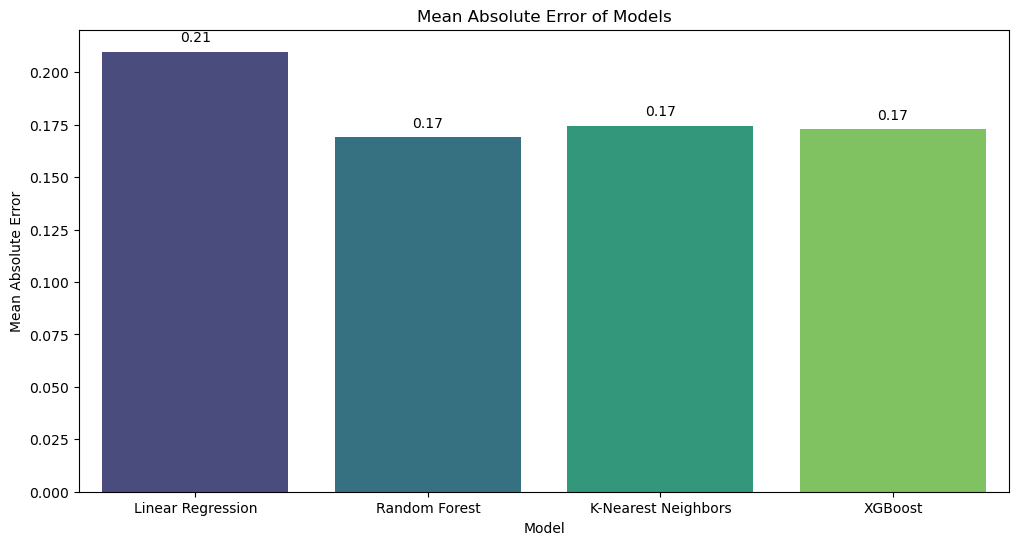

In [18]:
# Plotting the results
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x="Model", y="MAE", data=results, palette="viridis")
plt.title("Mean Absolute Error of Models")
plt.ylabel("Mean Absolute Error")

# Adding text labels for each bar
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.show()

/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_83498/1880841890.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Model", y="MSE", data=results, palette="viridis")
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

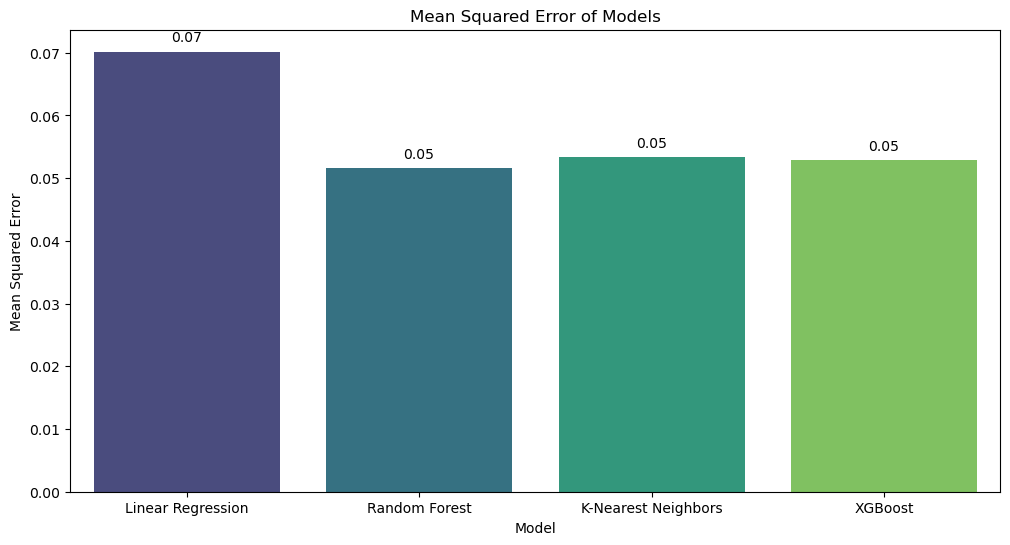

In [19]:
# Plotting the results
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x="Model", y="MSE", data=results, palette="viridis")
plt.title("Mean Squared Error of Models")
plt.ylabel("Mean Squared Error")

# Adding text labels for each bar
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.show()

/var/folders/9q/92k_9l3n5ns5d3nl7jnxq0gr0000gn/T/ipykernel_83498/1339538596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Model", y="R2", data=results, palette="viridis")
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = 

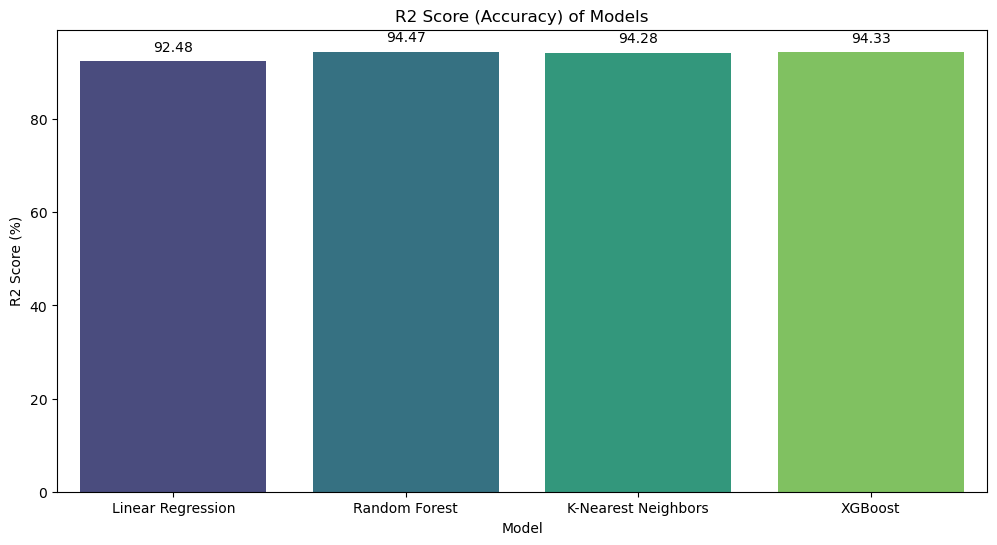

In [20]:
# Plotting the results
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x="Model", y="R2", data=results, palette="viridis")
plt.title("R2 Score (Accuracy) of Models")
plt.ylabel("R2 Score (%)")

# Adding text labels for each bar
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

plt.show()

In [21]:
class TestModels(unittest.TestCase):

    def setUp(self):
        self.models = {
            "Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(),
            "K-Nearest Neighbors": KNeighborsRegressor(),
            "XGBoost": XGBRegressor(),
        }
        self.pipelines = {
            name: Pipeline([("preprocessor", preprocessor), ("model", model)])
            for name, model in self.models.items()
        }
        self.data = df
        self.preprocess_data()

    def preprocess_data(self):
        window = 21 // 3
        self.data["timestamp"] = pd.to_datetime(self.data["timestamp"])
        self.data["date"] = self.data["timestamp"].dt.date
        grouped = self.data.groupby(["patient_id", "date"])
        daily_data = (
            grouped["blood_glucose"]
            .agg(["mean", "median", "std", "max", "min"])
            .reset_index()
        )
        daily_data["hba1c"] = grouped["hba1c"].first().values

        for feature in ["mean", "median", "std", "max", "min"]:
            daily_data[f"{feature}_rolling_mean"] = daily_data.groupby("patient_id")[
                feature
            ].transform(lambda x: x.rolling(window, min_periods=1).mean())
            daily_data[f"{feature}_rolling_std"] = daily_data.groupby("patient_id")[
                feature
            ].transform(lambda x: x.rolling(window, min_periods=1).std())

        daily_data["rolling_mean"] = daily_data[
            [
                f"{feature}_rolling_mean"
                for feature in ["mean", "median", "std", "max", "min"]
            ]
        ].mean(axis=1)
        daily_data["rolling_median"] = daily_data[
            [
                f"{feature}_rolling_mean"
                for feature in ["mean", "median", "std", "max", "min"]
            ]
        ].median(axis=1)
        daily_data["rolling_std"] = daily_data[
            [
                f"{feature}_rolling_std"
                for feature in ["mean", "median", "std", "max", "min"]
            ]
        ].std(axis=1)

        self.data = daily_data.dropna()[
            ["rolling_mean", "rolling_median", "rolling_std", "hba1c"]
        ]

    def test_models(self):
        X_test = self.data.drop("hba1c", axis=1)
        y_test = self.data["hba1c"]

        for name, pipeline in self.pipelines.items():
            pipeline.fit(X_test, y_test)
            predictions = pipeline.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            print(f"{name} MSE: {mse}")
            self.assertGreater(1.0, mse)


if __name__ == "__main__":
    unittest.main(argv=["first-arg-is-ignored"], exit=False)

Linear Regression MSE: 0.07135175693616098
Random Forest MSE: 0.00794691080027512
K-Nearest Neighbors MSE: 0.039822334326989214


/Users/hassanshahzad/anaconda3/envs/Conda-FYP-App/lib/python3.11/site-packages/xgboost/data.py:427: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
.
----------------------------------------------------------------------
Ran 1 test in 1.960s

OK


XGBoost MSE: 0.01869137630218715
